# Парсинг

In [ ]:
import typing as tp
import requests
import json

In [ ]:
def make_request(method_name, args: tp.Dict):
  args["access_token"] = "527fddd7527fddd7527fddd746516e1bf55527f527fddd731f08755e8750f232bec6580"
  args["v"] = "5.199"

  data = requests.get(f"https://api.vk.com/method/{method_name}", args)
  return json.loads(data.text)['response']


def get_count():
  count = make_request("wall.get", {"domain": "overhearitmo"})
  return count["count"]


def get_posts(offset = 0, count = 100):
  texts = []
  posts = make_request("wall.get", {"domain": "overhearitmo", "offset": offset, "count": count})["items"]
  for post in posts:
    post_text = post["text"]
    texts.append(post_text)
  return texts


posts = []
post_count = get_count()

count = 100
offset = 0

while post_count - offset >= count:
  texts = get_posts(offset, count)
  posts.extend(texts)
  offset += count

print(len(posts))

In [ ]:
import pandas as pd
from google.colab import files

f = open("posts.json", "w")
f.write(json.dumps(posts))

files.download("/content/posts.json")

print(posts[0])

# Предобработка

## Предварительная подготовка

In [ ]:
!pip3 install requests nltk pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 45.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=bf7428335db51a2a3fea5dd5eb6c84cd121136a4038e0f157f1486023c8558aa
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


Загрузка данных

In [ ]:
from google.colab import files

files.upload_file("posts.json")

In [ ]:
import json

raw_file = open("posts.json")
posts = json.loads(raw_file.read())

## Обработка текстовых данных

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy2
import nltk
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

morph = pymorphy2.MorphAnalyzer()

stemmer = SnowballStemmer("russian")
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
words = []
words_array = []

for post in posts:
  tokens = word_tokenize(post)
  stops = ['', 'в', 'не', 'а', 'и', 'я', ' ', 'https', 'http']

  # Удаляем стоп-слова
  filtered_tokens = [word.lower() for word in tokens]
  filtered_tokens = [word for word in filtered_tokens if word not in stop_words]
  # Стемминг
  # filtered_tokens = [stemmer.stem(word) for word in filtered_tokens]
  # Удаление знаков препинания и чисел
  filtered_tokens = [re.sub(r'[^\w\s]', '', word) for word in filtered_tokens]
  filtered_tokens = [re.sub(r'\d+', '', word) for word in filtered_tokens]
  filtered_tokens = [word.strip() for word in filtered_tokens if word.strip()]

  filtered_tokens = [word for word in filtered_tokens if word not in stops and len(word) > 2]
  filtered_tokens = [morph.normal_forms(word)[0] for word in filtered_tokens if word]

  words_array.append(filtered_tokens)
  words.extend(filtered_tokens)

In [ ]:
from google.colab import files
import json

filtered_tokens = open("filtered_tokens.json", "w")
filtered_tokens.write(json.dumps(words))

files.download("filtered_tokens.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Построение облака слов

In [ ]:
!pip install wordcount

  Preparing metadata (setup.py) ... done
  Created wheel for wordcount: filename=wordcount-1.0-py3-none-any.whl size=2151 sha256=29103dbee1f4f79a5fffc284e0160ba9c4e3a8e326e9d82ec8a0eab81af062f7
  Stored in directory: /root/.cache/pip/wheels/23/e2/ab/c0eee0c244d9bf90d06cb6086e699b999207efa0d54c1daa64
Successfully built wordcount


In [ ]:
from google.colab import files
import json

# files.upload_file("filtered_tokens.json")

In [ ]:
raw_data = open("filtered_tokens.json")
words = json.loads(raw_data.read())

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re

def replace_itmy(sentences):
  replaced_sentences = []
  for sentence in sentences:
    words = sentence.split()
    for i, word in enumerate(words):
      if word == "итмый":
        words[i] = "итмо"
    replaced_sentences.append(" ".join(words))
  return replaced_sentences

words = replace_itmy(words)

In [ ]:
from collections import Counter

unigram_counts = Counter(words)
bigrams = list(nltk.bigrams(words))
bigram_counts = Counter(bigrams)

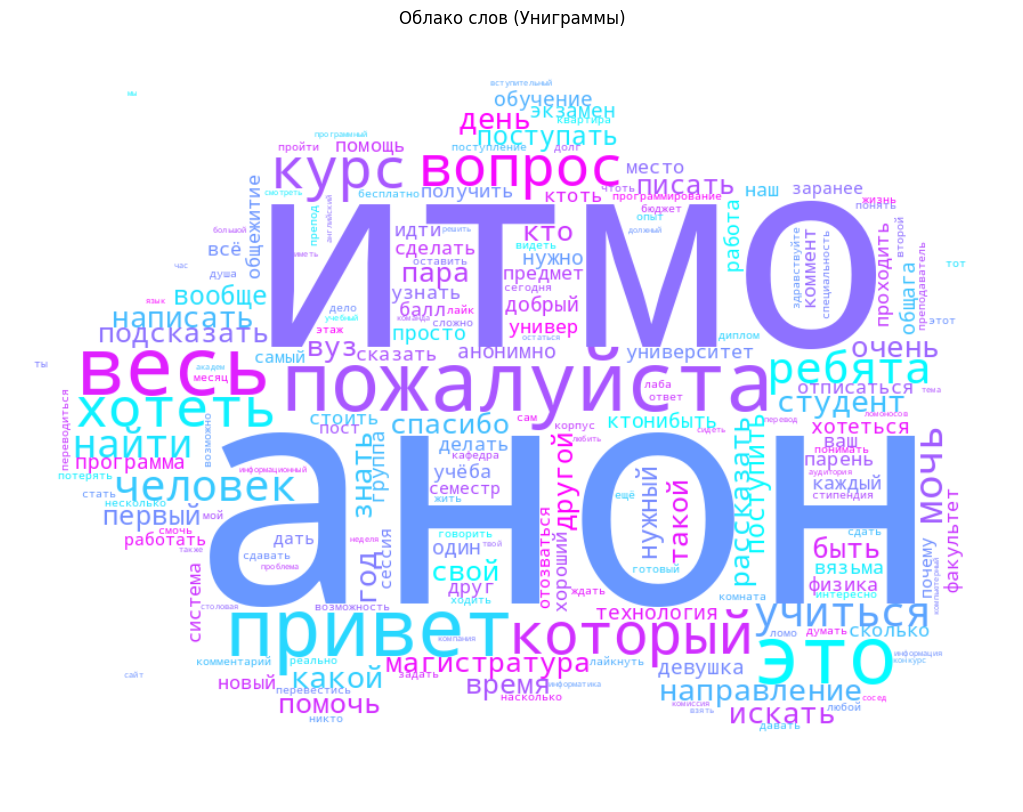

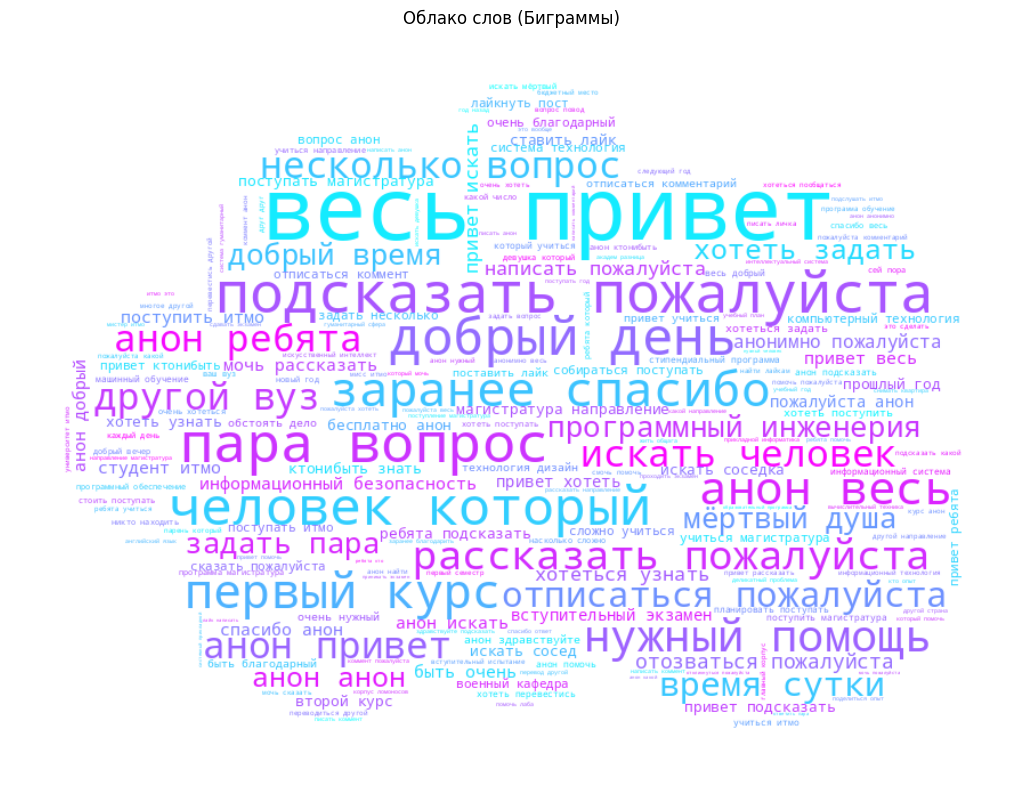

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from io import BytesIO
import numpy as np
import requests



def wc(frequencies, title):
  url = "https://www.pinclipart.com/picdir/middle/519-5194083_cloud-clipart.png"
  response = requests.get(url)
  cloud_mask = np.array(Image.open(BytesIO(response.content)))

  wordcloud = WordCloud(background_color="white", max_words=200, mask=cloud_mask, colormap="cool").generate_from_frequencies(frequencies)
  plt.figure(figsize=(20, 10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(title)
  plt.axis('off')
  plt.show()

wc(unigram_counts, 'Облако слов (Униграммы)')
bigram_str_counts = {' '.join(k): v for k, v in bigram_counts.items()}
wc(bigram_str_counts, 'Облако слов (Биграммы)')

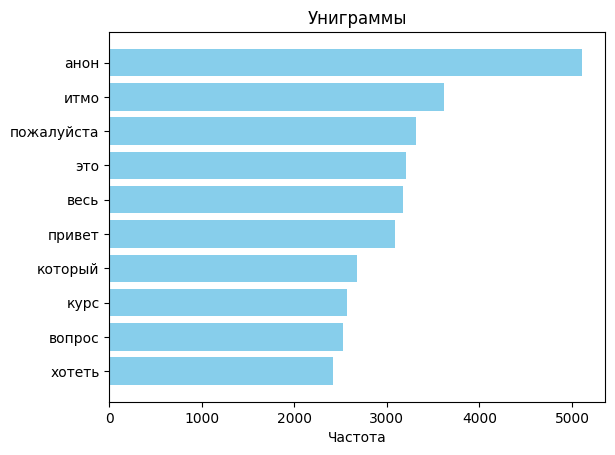

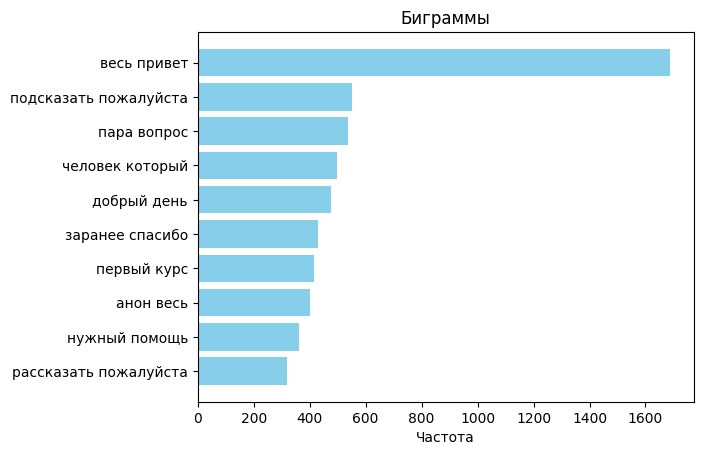

In [ ]:
def plot_frequency_bar_chart(frequencies, title, num=10):
    most_common = frequencies.most_common(num)
    labels, values = zip(*most_common)

    if isinstance(labels[0], tuple):
        labels = [' '.join(label) for label in labels]

    plt.barh(labels, values, color='skyblue')
    plt.xlabel('Частота')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_frequency_bar_chart(unigram_counts, 'Униграммы', num=10)
plot_frequency_bar_chart(bigram_counts, 'Биграммы', num=10)

### Анализ униграммы

1. **Анон** - больше всего в паблике преобладает желание быть анонимным, так как это подслушка
2. Как ни странно в паблике про ИТМО на втором месте находится сам **ИТМО**
3. На условном третьем месте слова связки - **который** и **это**
4. На четвертое место выделить можно выделить слова: **всем, привет, хочу, вопрос**, которые часто идут в связке
5. А также **курс**, так как вопросы обычно направлены с учетом определенного курса

### Анализ биграммы

Здесь также можем заметить преобладание слов приветствий, просьб и благодарностей. Но также большинство постов включают в себя **первый курс**, так как большинство постов оставлены абитуриентами, либо новоприбывшими первокурсниками.

# Тематическое моделирование

In [ ]:
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel
from tqdm import tqdm

def remove_items_from_nested_array(array, items_to_remove):
    return [[element for element in sublist if element not in items_to_remove] for sublist in array]

items = ['итмый', 'это', 'свой', 'наш', 'который', 'всё', 'весь', 'ваш']
words_array = remove_items_from_nested_array(words_array, items)

id2word = corpora.Dictionary(words_array)
corpus = [id2word.doc2bow(word) for word in words_array]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=words_array, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words_array, start=2, limit=20, step=1)

100%|██████████| 18/18 [07:43<00:00, 25.75s/it]


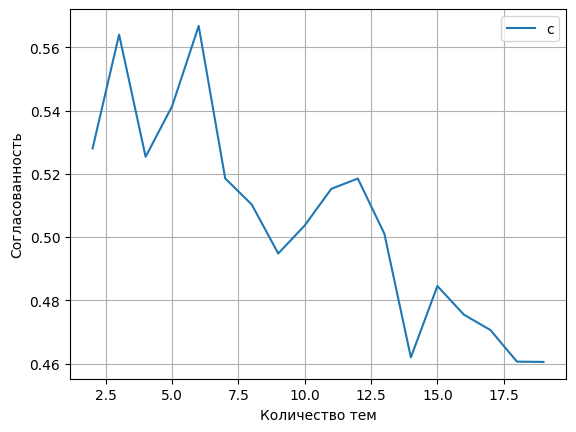

In [ ]:
import matplotlib.pyplot as plt
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

In [ ]:
n_topics = 6

In [ ]:
from gensim.models import LdaMulticore, CoherenceModel
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=n_topics)

In [ ]:
%%capture
!pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis
import os

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.081144 -0.118193       1        1  20.746132
4      0.007933 -0.067320       2        1  20.482192
3      0.117932  0.051046       3        1  19.877963
2      0.109173 -0.038476       4        1  13.473404
1     -0.177960  0.074436       5        1  13.082597
5      0.024065  0.098507       6        1  12.337712, topic_info=           Term         Freq        Total Category  logprob  loglift
7237     мистер   644.000000   644.000000  Default  30.0000  30.0000
622     девушка  1973.000000  1973.000000  Default  29.0000  29.0000
3368        цдо   665.000000   665.000000  Default  28.0000  28.0000
1565     парень  1337.000000  1337.000000  Default  27.0000  27.0000
691        лаба   631.000000   631.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
476       такой   225.200042  2007.963802   Topic6  -5.4325  -0.0954
66         анон   178.532580   962.491508   Topic6  -5.6647   0.4078
209   ктонибыть   162.037519   684.849442   Topic6  -5.7617   0.6511
500        друг   174.703073  1000.120284   Topic6  -5.6864   0.3477
1           год   195.949159  2021.483177   Topic6  -5.5716  -0.2412

[515 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5753      6  0.976366  администратор
6902      4  0.969335          актив
7707      5  0.973791     алексеевич
6386      3  0.194767     альпийский
6386      5  0.759593     альпийский
...     ...       ...            ...
5546      1  0.096306           явно
5546      4  0.880511           явно
5546      5  0.013758           явно
931       4  0.978108       языковой
931       6  0.010748       языковой

[1396 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2, 6])

In [ ]:
lda_model.print_topics()

[(0,
  '0.007*"человек" + 0.007*"студент" + 0.006*"каждый" + 0.006*"день" + 0.006*"друг" + 0.005*"такой" + 0.005*"время" + 0.005*"самый" + 0.005*"жизнь" + 0.005*"год"'),
 (1,
  '0.017*"девушка" + 0.013*"парень" + 0.007*"вязьма" + 0.007*"столовая" + 0.006*"почему" + 0.006*"общага" + 0.006*"такой" + 0.006*"подслушать" + 0.005*"найти" + 0.005*"этаж"'),
 (2,
  '0.012*"курс" + 0.011*"мистер" + 0.010*"цдо" + 0.009*"лаба" + 0.008*"помочь" + 0.007*"мисс" + 0.007*"первый" + 0.006*"экзамен" + 0.006*"ребята" + 0.006*"долг"'),
 (3,
  '0.012*"вопрос" + 0.010*"пожалуйста" + 0.010*"привет" + 0.010*"ребята" + 0.009*"общага" + 0.009*"хотеть" + 0.009*"учиться" + 0.007*"быть" + 0.007*"рассказать" + 0.006*"общежитие"'),
 (4,
  '0.009*"хотеть" + 0.009*"знать" + 0.008*"универ" + 0.007*"год" + 0.007*"учиться" + 0.007*"человек" + 0.007*"один" + 0.007*"такой" + 0.007*"вообще" + 0.006*"поступить"'),
 (5,
  '0.012*"пара" + 0.011*"сегодня" + 0.008*"пожалуйста" + 0.008*"ребята" + 0.007*"найти" + 0.007*"очень" + 0.

1. Отстраненные истории и вопросы студентов
2. Вопросы про учебные дисциплины
3. Вопросы про поступлениев университет
4. Вопросы про экзамены, долги, сдачи
5. Вопросы про общагу и место жительства
6. Неопределенная категория, другие вопросы

In [ ]:
n_topics = 3
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=n_topics)
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.111372 -0.017612       1        1  51.201503
1      0.074150 -0.070869       2        1  25.554812
0      0.037223  0.088480       3        1  23.243685, topic_info=         Term         Freq        Total Category  logprob  loglift
622   девушка  1957.000000  1957.000000  Default  30.0000  30.0000
469      пара  1384.000000  1384.000000  Default  29.0000  29.0000
471    почему   695.000000   695.000000  Default  28.0000  28.0000
13    учиться  2418.000000  2418.000000  Default  27.0000  27.0000
1565   парень  1299.000000  1299.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1         год   357.583716  2104.318430   Topic3  -5.6035  -0.3132
228    вопрос   323.480426  1598.272440   Topic3  -5.7037  -0.1384
92     ребята   319.707055  2055.046426   Topic3  -5.7155  -0.4015
622   девушка   278.859552  1957.142730   Topic3  -5.8522  -0.4894
343   студент   271.095187  1826.159841   Topic3  -5.8804  -0.4484

[294 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
16018      1  0.989010    daad
3304       1  0.989730     ios
16020      1  0.976974    neso
16021      1  0.976974  nuffic
959        1  0.975912  андрей
...      ...       ...     ...
2720       2  0.685543    этаж
2720       3  0.232349    этаж
5545       1  0.077284    юмор
5545       2  0.875890    юмор
5545       3  0.051523    юмор

[622 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [ ]:
lda_model.print_topics()

[(0,
  '0.007*"такой" + 0.007*"пара" + 0.006*"хотеть" + 0.006*"знать" + 0.006*"универ" + 0.005*"один" + 0.005*"очень" + 0.005*"почему" + 0.005*"общага" + 0.004*"человек"'),
 (1,
  '0.010*"девушка" + 0.007*"человек" + 0.006*"парень" + 0.006*"день" + 0.005*"найти" + 0.004*"курс" + 0.004*"такой" + 0.004*"сидеть" + 0.004*"каждый" + 0.004*"первый"'),
 (2,
  '0.010*"учиться" + 0.007*"хотеть" + 0.007*"ребята" + 0.007*"курс" + 0.006*"год" + 0.006*"пожалуйста" + 0.006*"поступить" + 0.006*"студент" + 0.006*"вопрос" + 0.005*"день"')]

1. Вопросы по учебному процессу, поступлению, экзаменам
2. Общие вопросы
3. Вопросы про корпуса и общаги

### Анализ результатов

Как можно увидеть, при меньшем количестве кластеров, становится сложнее определять категории, поэтому 6 разбиений достаточно для того, чтобы понимать ситуацию, большее количество будет излишним, а также будет меньше согласованность


# Анализ тональности документов

In [ ]:
%%capture
!pip install dostoevsky
!python -m dostoevsky download fasttext-social-network-model

In [ ]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

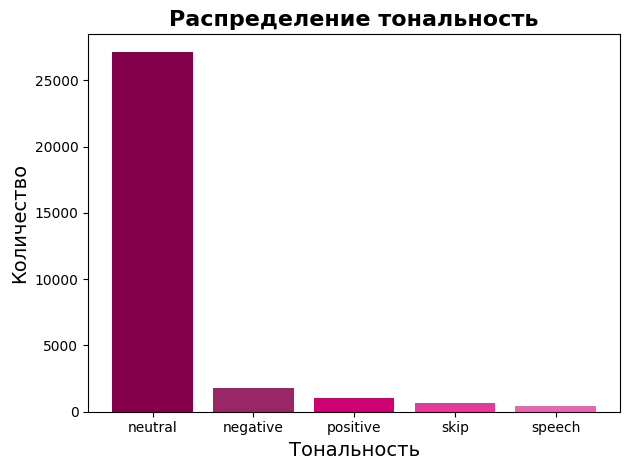

In [ ]:
import matplotlib.pyplot as plt


results = model.predict(posts, k=1)
sent = []

for post, sentiment in zip(posts, results):
    sent.append(list(sentiment.keys())[0])

sentiments = dict(zip(posts, sent))

sentiment_counts = {}
for sentiment in sent:
    if sentiment in sentiment_counts:
        sentiment_counts[sentiment] += 1
    else:
        sentiment_counts[sentiment] = 1

sentiment_counts = dict(sorted(sentiment_counts.items(), key=lambda item: item[1], reverse=True))

plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['#85004B', '#992667', '#CD0074', '#E6399B', '#E667AF'])
plt.xlabel("Тональность", fontsize=14)
plt.ylabel("Количество", fontsize=14)
plt.title("Распределение тональность", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
print("Тональность | Количество")
print("----------|------------")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment:} | {count:}")

Тональность | Количество
----------|------------
neutral | 27117
negative | 1765
positive | 1024
skip | 679
speech | 415


### Анализ результатов

Как можно заметить большинство постов преобладают нейтральным окрасом, что неудивительно, но следом за ним следуют посты отрицательной тональности. А также по причине того, что многие публикации анонимные, они могут содержать негативное содержание за счет ощущения безнаказанности.

# Построение графовой модели корпуса

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

In [ ]:
def vis_graph(G, title='Графовая модель корпуса'):
    pos = nx.spring_layout(G, k=2.5, iterations=50)

    node_sizes = [700 + 100 * nx.degree(G, n) for n in G.nodes()]

    plt.figure(figsize=(20, 15))

    # Узлы
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='orange')

    # Ребра
    edge_weights = [G[u][v]['weight'] / 200 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, edge_color='grey')

    # Метки узлов
    nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif', font_color='black')

    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

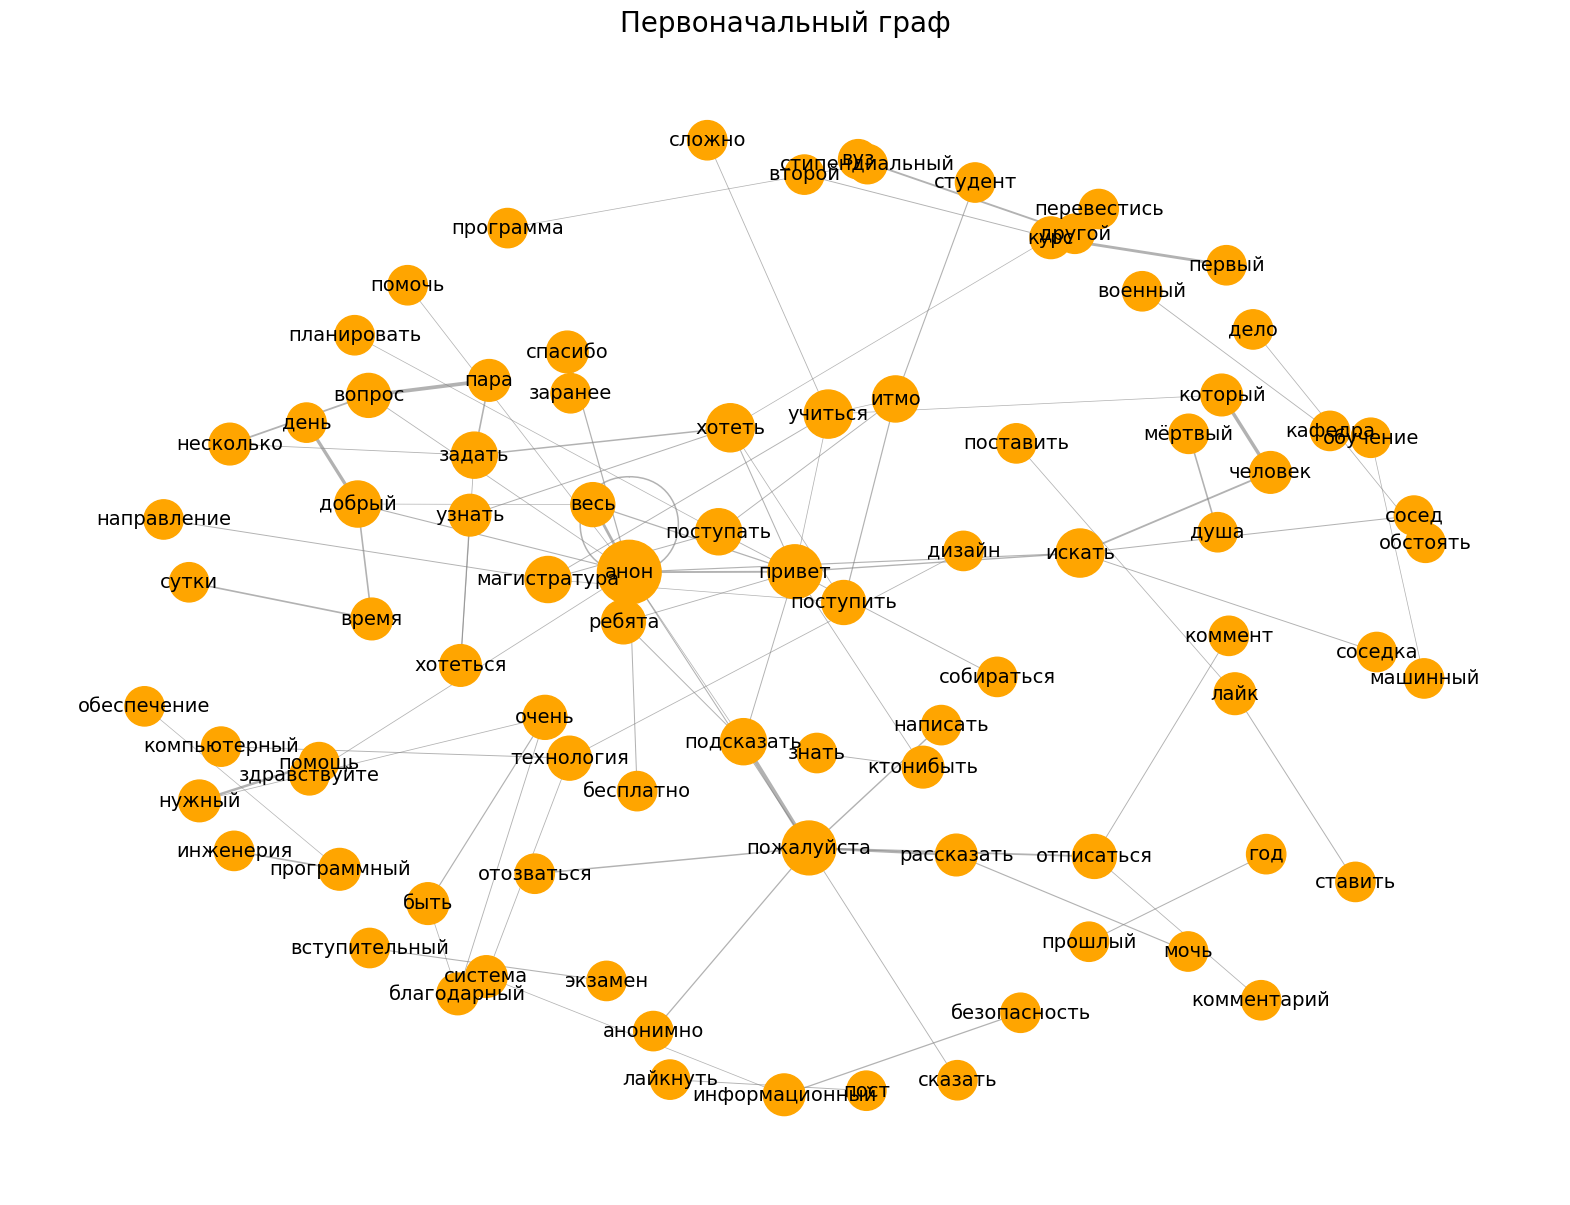

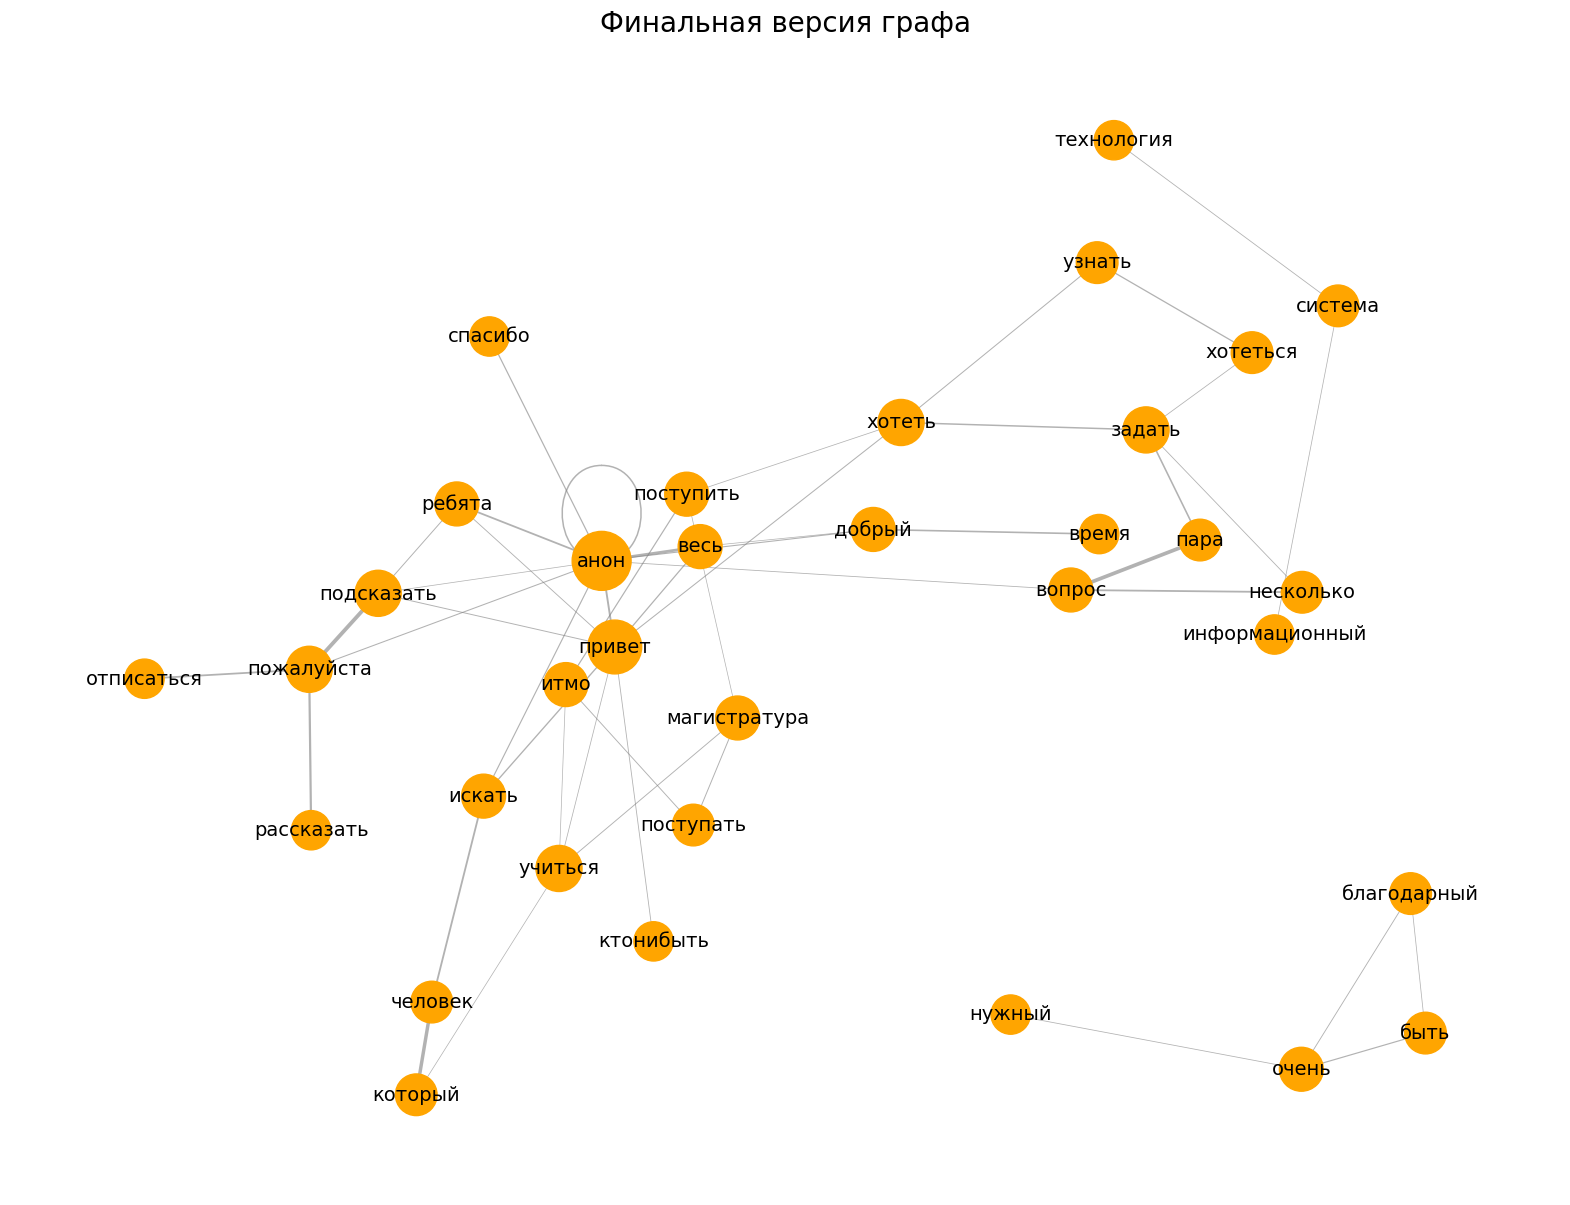

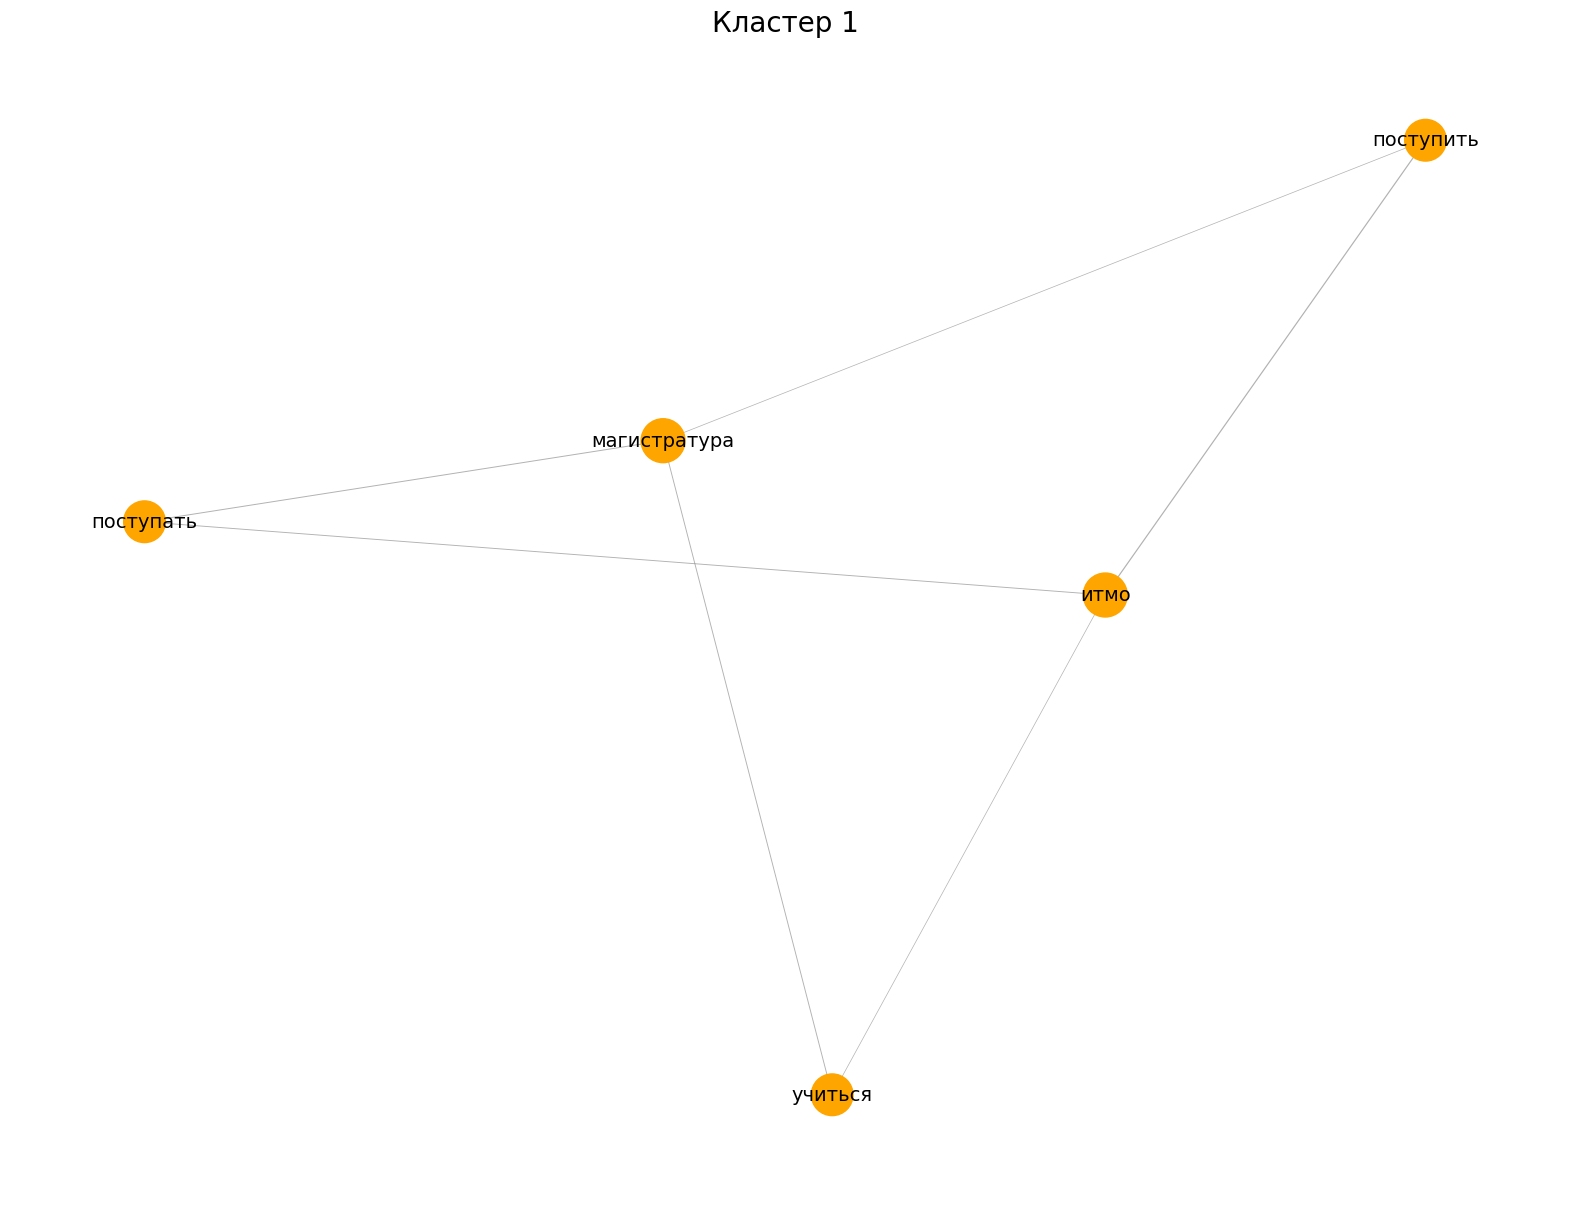

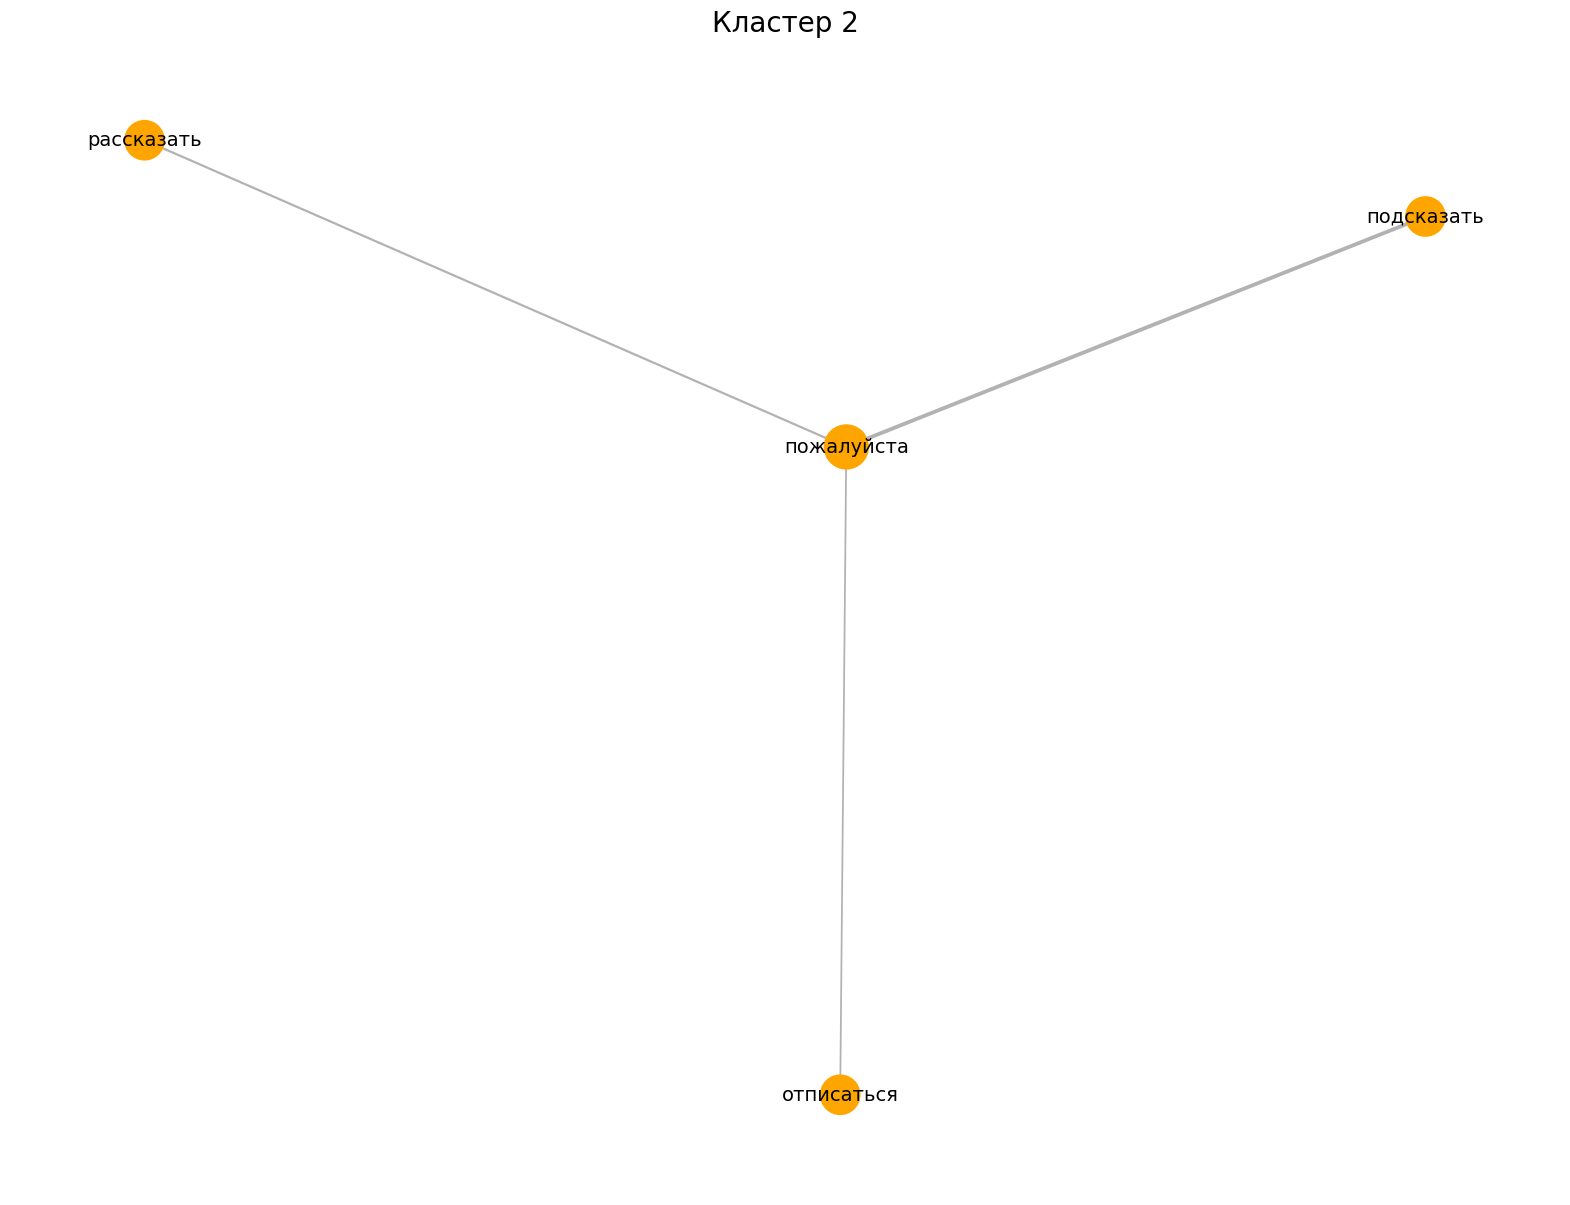

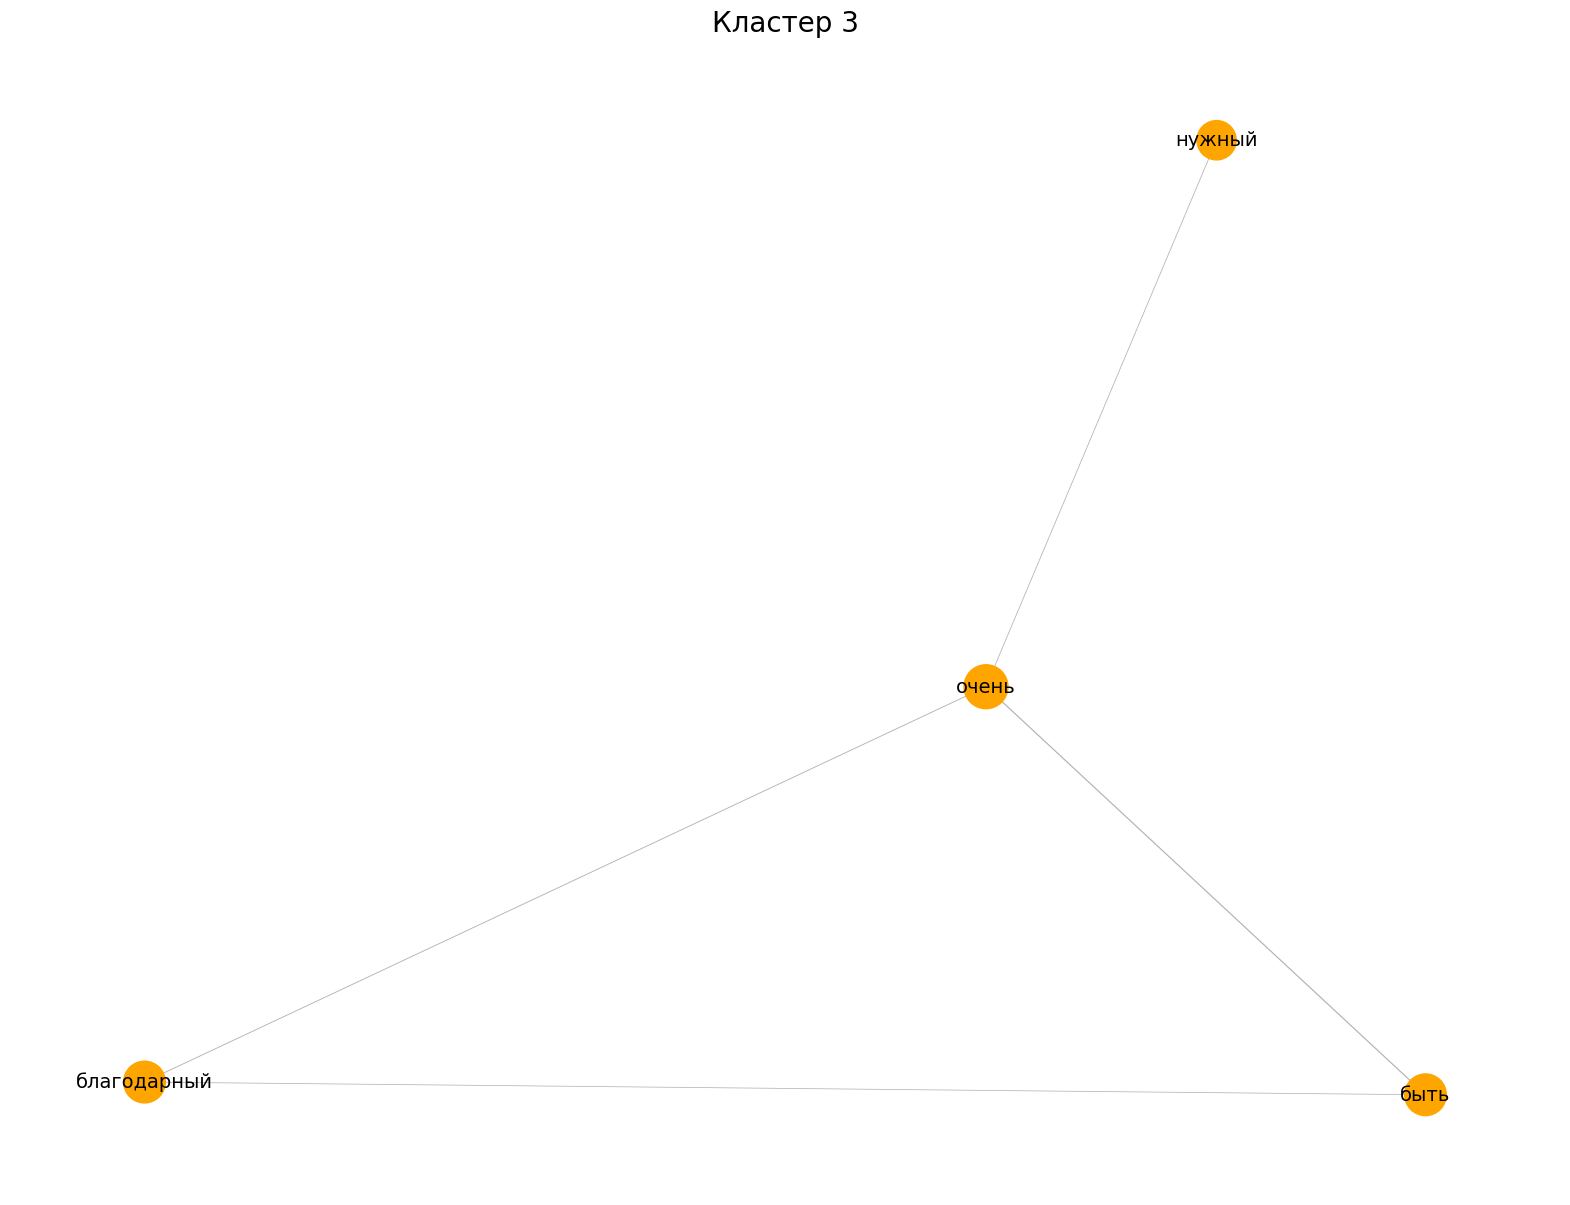

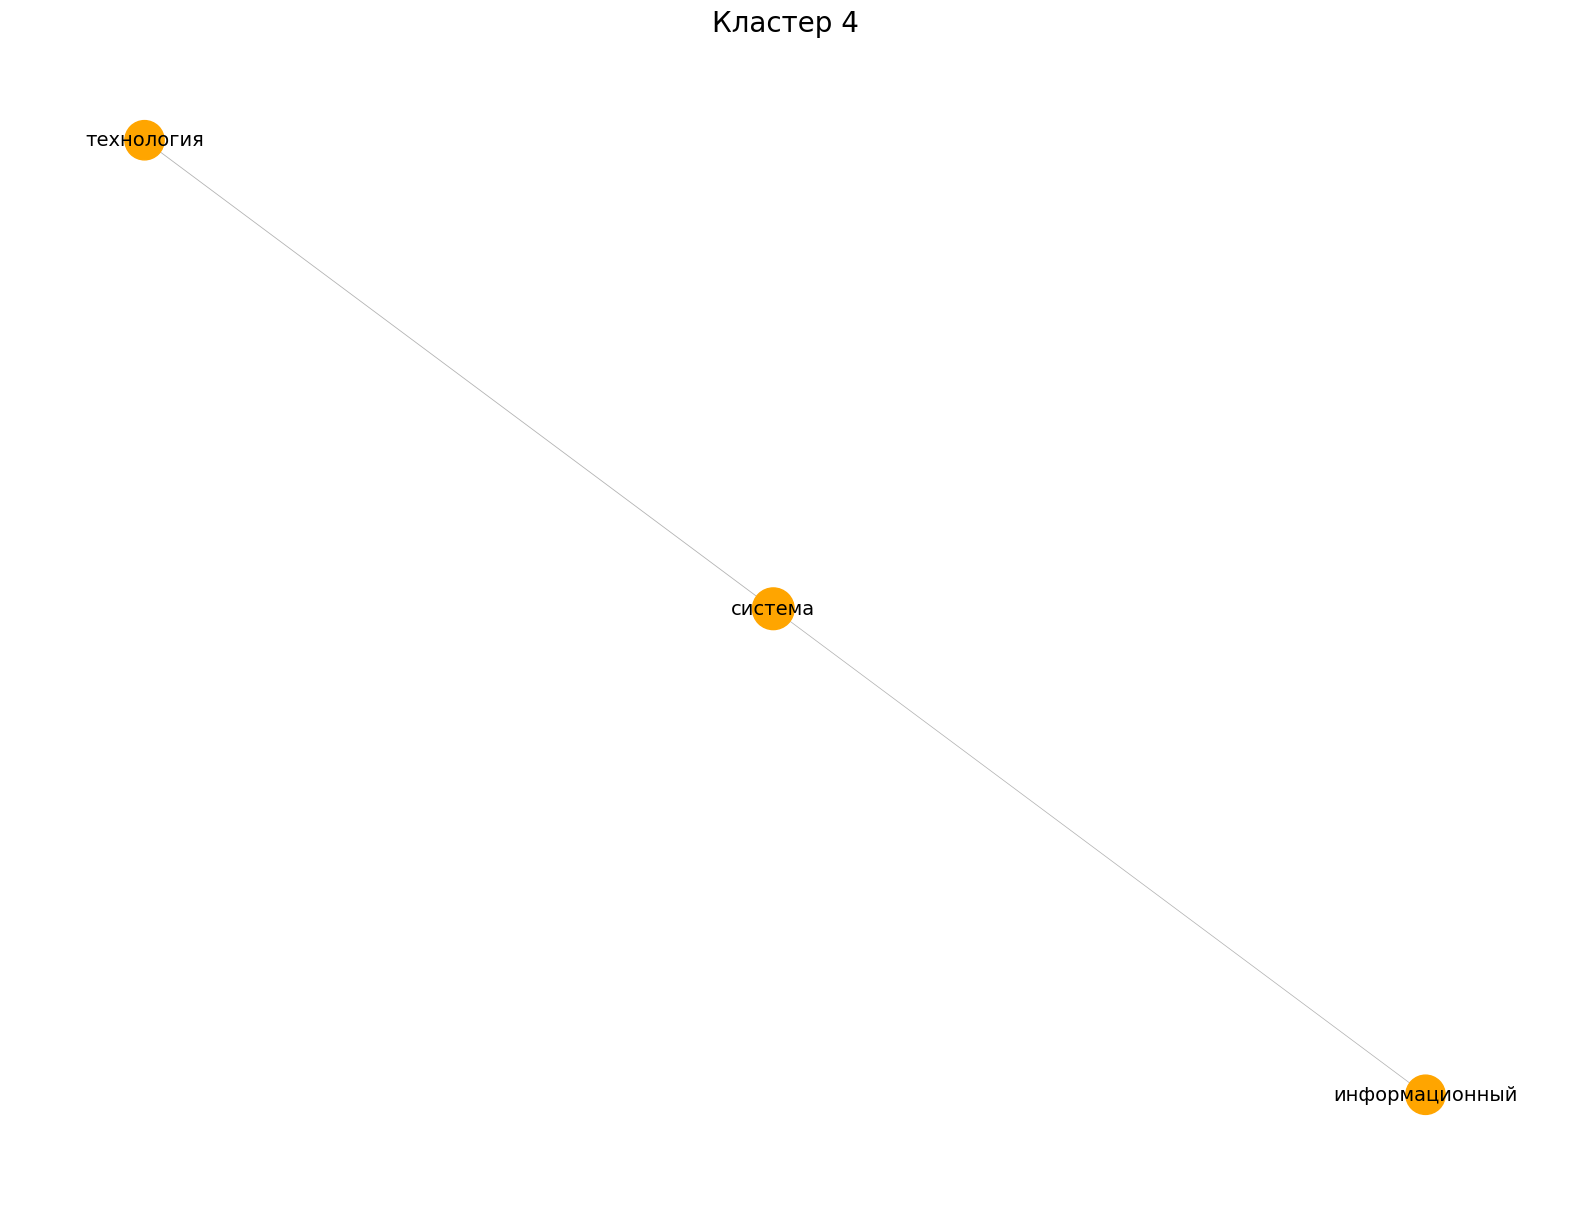

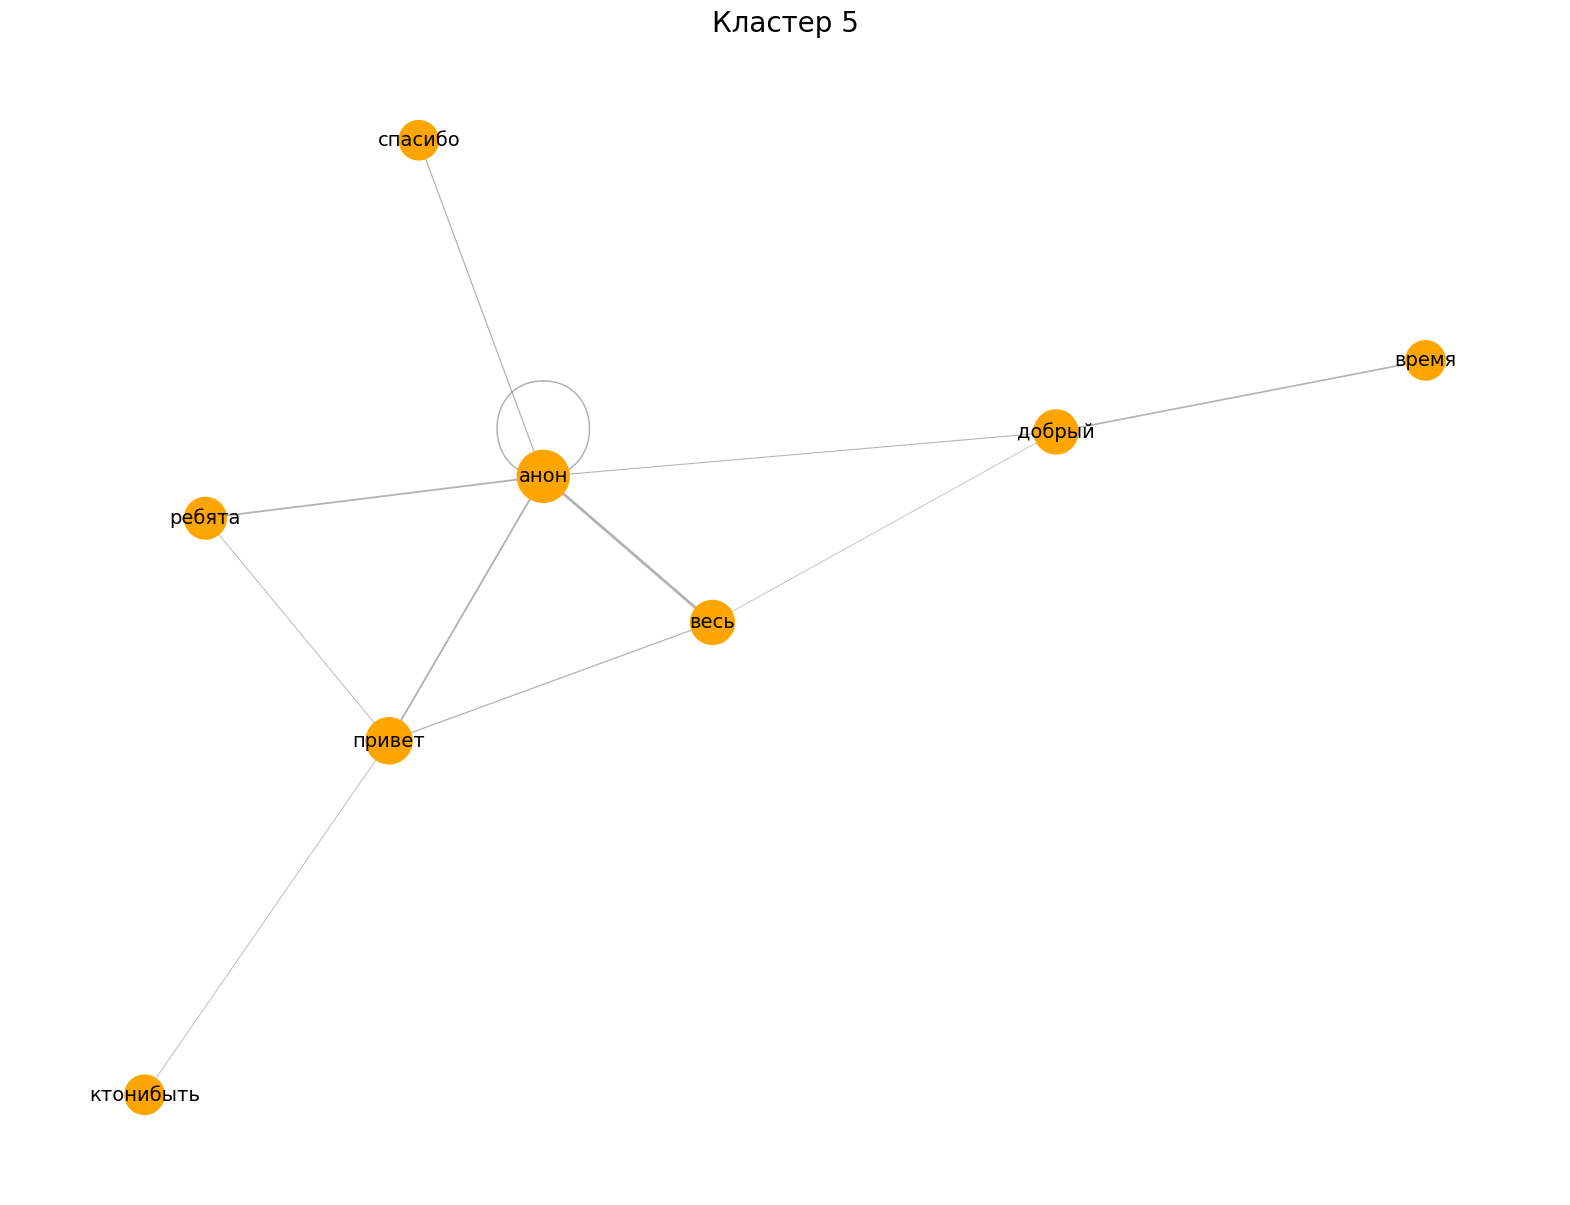

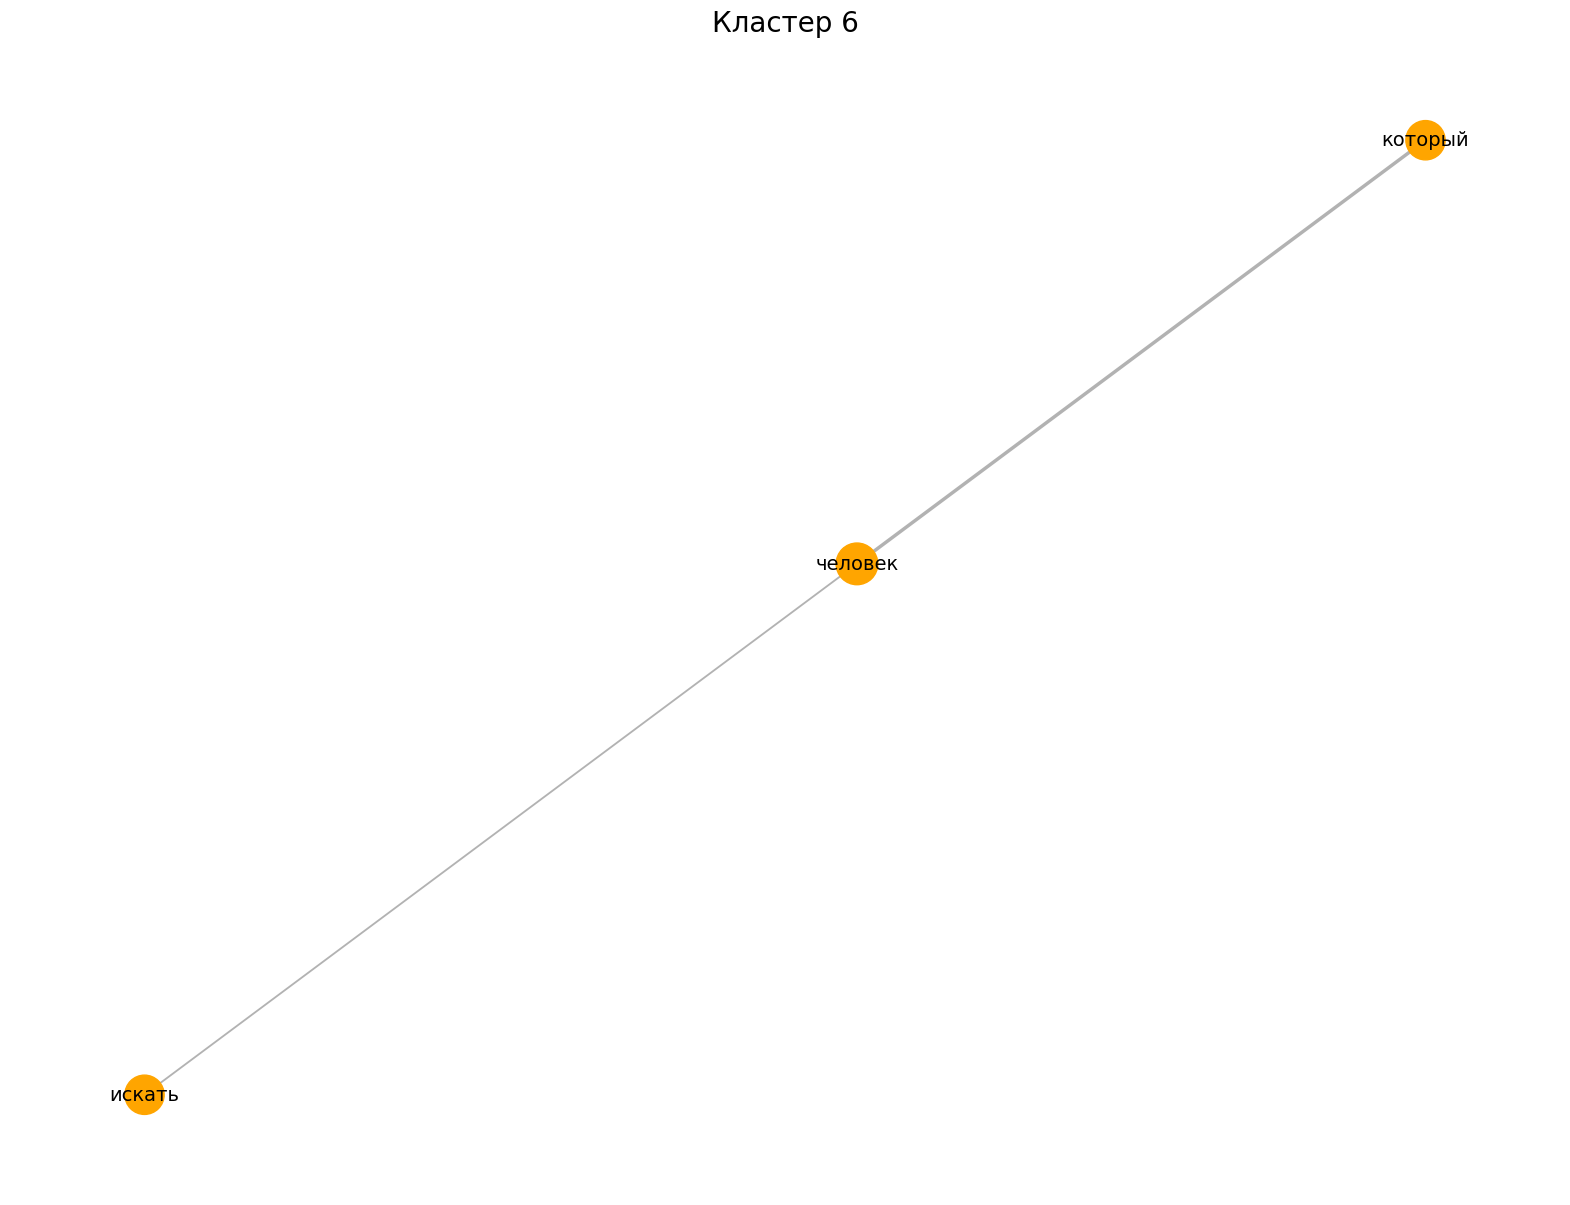

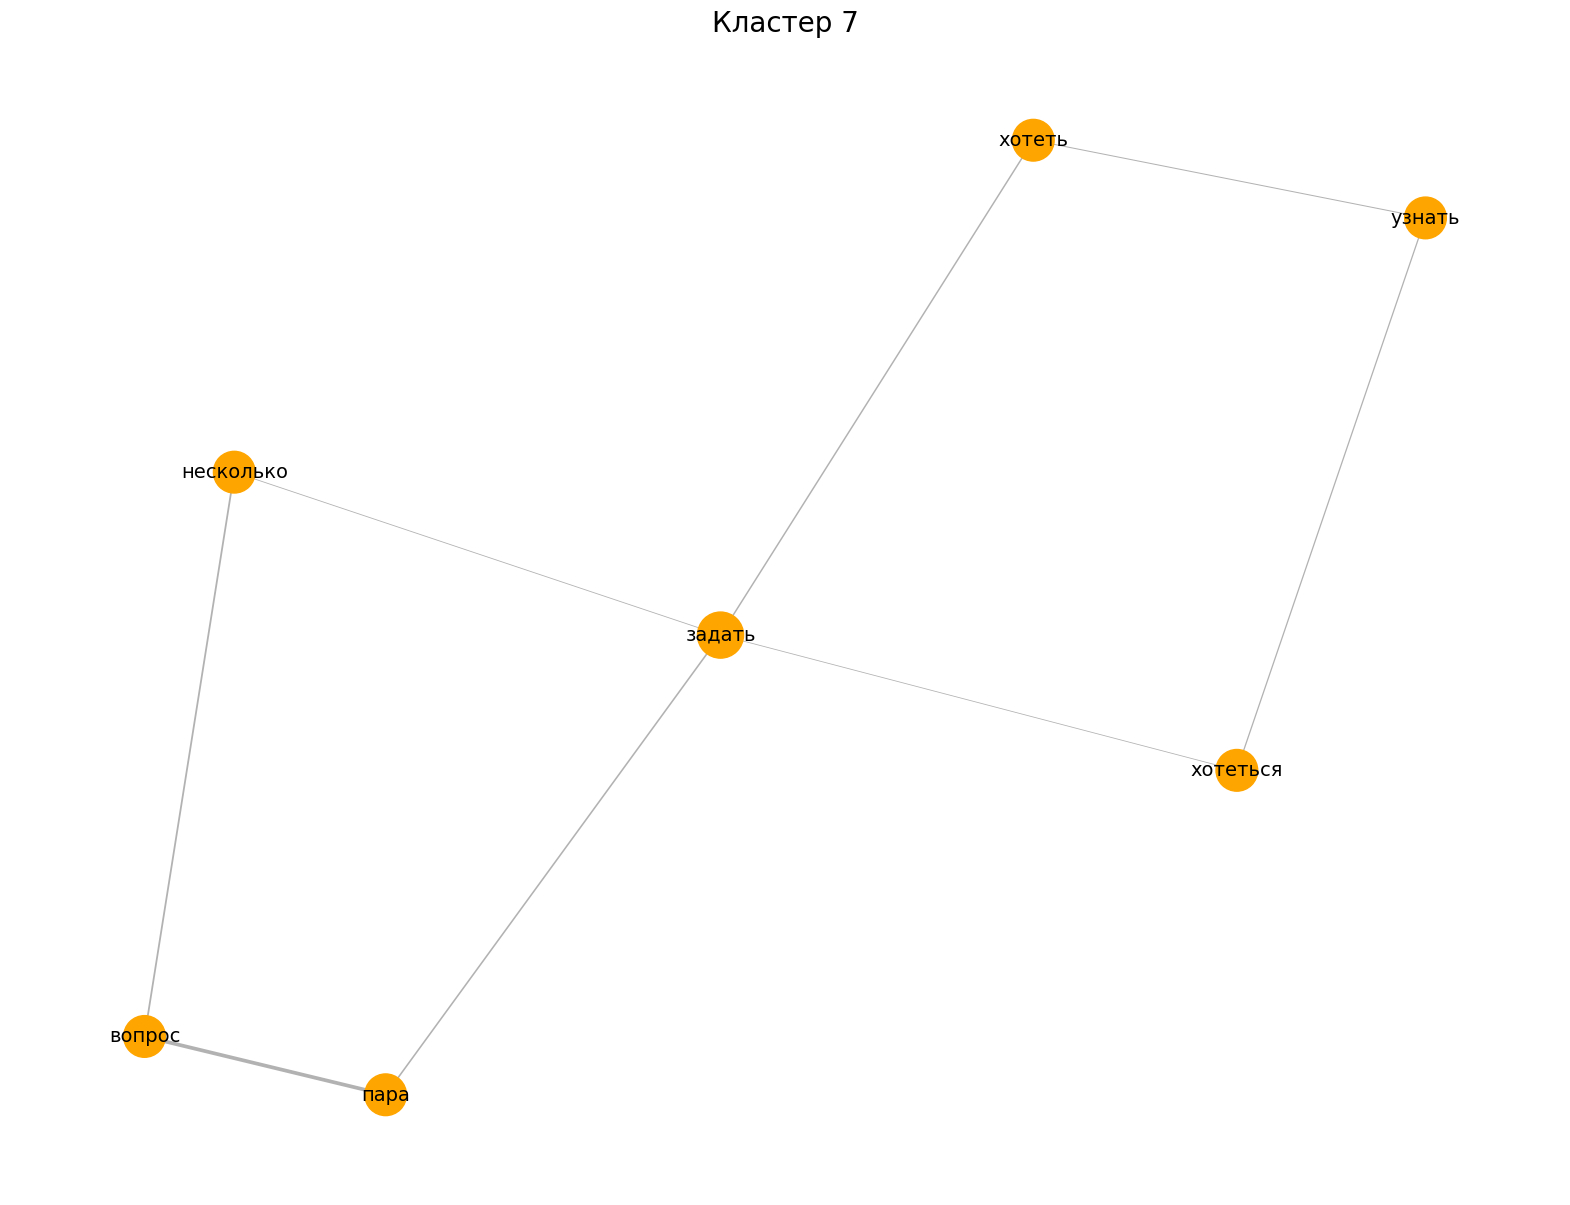

In [ ]:
graph = nx.Graph()

# Порог для включения биграмм
threshold = 100

for bigram, weight in bigram_counts.items():
    if weight >= threshold:
        word1, word2 = bigram
        graph.add_edge(word1, word2, weight=weight)

vis_graph(graph, 'Первоначальный граф')

# Удаление узлов с степенью менее 2
remove = [node for node, degree in dict(graph.degree()).items() if degree < 2]
graph.remove_nodes_from(remove)

# vis_graph(graph, 'Граф после удаления узлов с степенью менее 2')

# Удаление ребер, которые соединяют узлы из удаленного списка
remove_edge = [pair for pair in graph.edges() if pair[0] in remove or pair[1] in remove]
graph.remove_edges_from(remove_edge)

# vis_graph(graph, 'Граф после удаления ненужных ребер')

# Удаление оставшихся узлов с нулевой степенью
remove = [node for node, degree in dict(graph.degree()).items() if degree < 1]
graph.remove_nodes_from(remove)

# Финальная визуализация
vis_graph(graph, 'Финальная версия графа')

communities = louvain_communities(graph)

# Создание субграфов для каждого кластера
subgraphs = [graph.subgraph(c).copy() for c in communities]

# Визуализация каждого субграфа
for i, sg in enumerate(subgraphs):
    if len(sg.nodes) > 1:
        vis_graph(sg, f'Кластер {i+1}')



### Анализ графа и кластеров

Из-за большого объема данных граф даже после обработки остается слегка запутанным, поэтому мы разбили его на кластеры, которое уже можно спокойно анализировать.

1. Первый кластер говорит про посты связанные с магистратурой, где люди уже поступили или собираются поступать в итмо.
2. Второй кластер относится к привественным фразам
3. Третий кластер описывает слова искренней потребности или благодарности, связанные словом **очень**
4. Так как мы техническо-информационный вуз, то в четвертом кластере задействуются слова относящиеся к большинству специальностей
5. В пятом кластере указаны снова слова потребности
6. В шестом кластере описаны слова, которые используются для поиска людей скорее всего для помощи, либо мертвой души
7. В седьмом кластере указаны слова-вопросы, которые часто используются в одной связке во вступительной части поста